# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or

to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit, udf, isnan, count, when, desc, sort_array, asc, avg, lag, floor
from pyspark.sql.types import IntegerType, DateType
import matplotlib.pyplot as plt
from pyspark.sql.window import Window
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import MinMaxScaler 
from pyspark.sql.types import DoubleType
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, LinearSVC, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.sql.functions import avg
from pyspark.sql.functions import max as Fmax
import datetime

In [2]:
# create a Spark session
spark = SparkSession.builder \
    .master("local") \
    .appName("Pablo's Session") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = 'mini_sparkify_event_data.json'
df = spark.read.json(path)
# Print schema for data frame 
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [4]:
#check of the data
df.head(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

In [5]:
# gives number of non null row 
df.count() 

286500

In [6]:
# gives number of col count
len(df.columns) 

18

In [7]:
#check if there are an null values in session id
print(f"Empty session id: {df.filter(df.sessionId == '').count()}")

Empty session id: 0


In [8]:
#check if there are an null in user id 
print(f"Empty user id: {df.filter(df.userId == '').count()}")

Empty user id: 8346


In [9]:
# keep only the rows with no null in user Id 
df = df.where(df.userId != "")

In [10]:
#check the null again
print(f"Empty user id: {df.filter(df.userId == '').count()}")

Empty user id: 0


In [11]:
# gives number of non null row 
df.count() 

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [12]:
# Describe statistics of the df
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,count,228108,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154,278154,278154,228108,278154,278154,278154,278154
1,mean,551.0852017937219,None,None,None,114.89918174824018,None,249.1171819778458,None,None,None,None,1.5353588340844272E12,1042.5616241362698,Infinity,209.10321620397335,1.5409589154318713E12,None,59682.02278593872
2,stddev,1217.7693079161374,None,None,None,129.851729399489,None,99.23517921058361,None,None,None,None,3.291321616327586E9,726.5010362219813,NaN,30.151388851328214,1.5068287123306298E9,None,109091.9499991047
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",GET,About,1521380675000,1,ÃÂg ÃÂtti GrÃÂ¡a ÃÂsku,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10
4,max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",PUT,Upgrade,1543247354000,2474,ÃÂau hafa sloppiÃÂ° undan ÃÂ¾unga myrkursins,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99


In [13]:
#check how many  user id
df.select("userId").dropDuplicates().count()

225

In [14]:
# check the top sessions count of each user id
df.select('userId').groupBy('userId').count().sort('count', ascending = False).show()

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
|     6| 3761|
|    29| 3603|
|    54| 3437|
|   100| 3214|
|     9| 3191|
|   126| 3102|
|300015| 3051|
|    91| 3014|
|    98| 2891|
|    74| 2887|
+------+-----+
only showing top 20 rows



In [15]:
# check the pages values
df.select('page').dropDuplicates().show()

+--------------------+
|                page|
+--------------------+
|              Cancel|
|    Submit Downgrade|
|         Thumbs Down|
|                Home|
|           Downgrade|
|         Roll Advert|
|              Logout|
|       Save Settings|
|Cancellation Conf...|
|               About|
|            Settings|
|     Add to Playlist|
|          Add Friend|
|            NextSong|
|           Thumbs Up|
|                Help|
|             Upgrade|
|               Error|
|      Submit Upgrade|
+--------------------+



In [16]:
# check the pages values
df.select('gender').dropDuplicates().show()

+------+
|gender|
+------+
|     F|
|     M|
+------+



In [17]:
# check the auth values
df.select('auth').dropDuplicates().show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [18]:
# check the location values
df.select('location').dropDuplicates().show()

+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
+--------------------+
only showing top 20 rows



In [19]:
# check the sessions count of each pages
df.select('page').groupBy('page').count().sort('count', ascending = False).show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [20]:
def set_churn_field(df, churn_event):
    """
        Adds a field column to the dataframe using the churn state. flag is 0 or 1.
        This function can be used to create two types of field: Cancellation churn (i.e a user
        leaves the service) or downgrade churn (i.e. the user downgrade the subscription
        from paid to free)
        
        Input:
            df - the dataframe to use
            churn_event - whether we want to add labels for Cancellation churn or downgrade churn
        Output:
            df_churn - the input dataframe with an additional label column
    """
    
    if churn_event == 'Submit Downgrade':
        flag_col_name = "downgraded"
        phase_col_name = "phase_downgrade"
        label_col_name = "churn_paid"
    elif churn_event == 'Cancellation Confirmation':
        flag_col_name = "cancelled"
        phase_col_name = "phase_cancel"
        label_col_name = "churn_cancelled"
    
    # we create a flag for the special event
    flag_event = udf(lambda x: 1 if x == churn_event else 0, IntegerType())
    
    # we create a new column with the value of the flag
    df_event = df.withColumn(flag_col_name, flag_event("page"))
    
    # create a phase column to distinguish the change of status
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    df_phase = df_event.withColumn(phase_col_name, Fsum(flag_col_name).over(windowval))
    
    #add a churn label to each user
    df= df_phase.withColumn(label_col_name, Fmax(flag_col_name).over(Window.partitionBy("userId")))
    
    return df


In [21]:
# set churn for both (Cancellation Confirmation) and (Submit Downgrade)
df = set_churn_field(df, 'Submit Downgrade')
df =  set_churn_field(df, 'Cancellation Confirmation')

In [22]:
#display new dataframe
df.select(['userId', 'level' ,'page', 'cancelled', 'phase_cancel', 'churn_cancelled', 'downgraded', 'phase_downgrade', 'churn_paid']).orderBy(['userId']).dropDuplicates().show(30)

+------+-----+---------------+---------+------------+---------------+----------+---------------+----------+
|userId|level|           page|cancelled|phase_cancel|churn_cancelled|downgraded|phase_downgrade|churn_paid|
+------+-----+---------------+---------+------------+---------------+----------+---------------+----------+
|    10| paid|      Downgrade|        0|           0|              0|         0|              0|         0|
|    10| paid|       NextSong|        0|           0|              0|         0|              0|         0|
|    10| paid|           Home|        0|           0|              0|         0|              0|         0|
|    10| paid|         Logout|        0|           0|              0|         0|              0|         0|
|    10| paid|Add to Playlist|        0|           0|              0|         0|              0|         0|
|    10| paid|      Thumbs Up|        0|           0|              0|         0|              0|         0|
|    10| paid|     Add Frien

In [23]:
#check the new colomn
df.describe().toPandas()

,summary,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,...,status,ts,userAgent,userId,downgraded,phase_downgrade,churn_paid,cancelled,phase_cancel,churn_cancelled
0,count,228108,278154,278154,278154,278154,278154,228108,278154,278154,...,278154,278154,278154,278154,278154,278154,278154,278154,278154,278154
1,mean,551.0852017937219,None,None,None,114.89918174824018,None,249.11718197783495,None,None,...,209.10321620397335,1.5409589154318582E12,None,59682.02278593872,2.2649323755905002E-4,0.30953356773585855,0.38342788527218735,1.869467992550889E-4,0.16129194618808287,0.16129194618808287
2,stddev,1217.7693079161377,None,None,None,129.85172939949013,None,99.23517921058327,None,None,...,30.151388851327837,1.5068287123362646E9,None,109091.94999910559,0.015048014901098866,0.6575122986359151,0.48622195754530645,0.013671595449116164,0.36780068056308857,0.36780068056308857
3,min,!!!,Cancelled,Adelaida,F,0,Adams,0.78322,free,"Albany, OR",...,200,1538352117000,"""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10)...",10,0,0,0,0,0,0
4,max,ÃÂlafur Arnalds,Logged In,Zyonna,M,1321,Wright,3024.66567,paid,"Winston-Salem, NC",...,404,1543799476000,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,99,1,3,1,1,1,1


## Explore Data
 
Checking the total users  and how many user did cancel the service, and how many did downgrade.

In [24]:
# check the number of all users 
df.select("userId").dropDuplicates().count()

225

In [25]:
#check the user cancel the service
churn_cancelled = df.select('userId').where(df['churn_cancelled']==1).dropDuplicates().count()
print('{} Users unsubscribed from the service'.format(churn_cancelled))
print('{:.2f}% unsubscribed: '.format(churn_cancelled/df.select("userId").dropDuplicates().count()*100))

52 Users unsubscribed from the service
23.11% unsubscribed: 


In [26]:
#check the user downgraded
churn_paid = df.select('userId').where(df['churn_paid']==1).dropDuplicates().count()
print('{} Users downgraded from paid to free service '.format(churn_paid))
print('{:.2f}% downgraded: '.format(churn_paid/df.select("userId").dropDuplicates().count()*100))

49 Users downgraded from paid to free service 
21.78% downgraded: 


In [27]:
print('Users downgraded from paid to free, and then cancelled the service:')
df.select('userId').where((df['churn_paid']==1)&(df['churn_cancelled']==1)).dropDuplicates().show()

Users downgraded from paid to free, and then cancelled the service:
+------+
|userId|
+------+
|    54|
|100025|
|100009|
|100015|
|   103|
|100012|
|200020|
|200011|
|    12|
+------+



In [28]:
#explore data for one user to see the downgrade of services
df.select(['userId', 'level', 'page']).where((df['userId']=='100025')).sort(desc('ts')).show(240)

+------+-----+--------------------+
|userId|level|                page|
+------+-----+--------------------+
|100025| free|Cancellation Conf...|
|100025| free|              Cancel|
|100025| free|         Roll Advert|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|         Thumbs Down|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|         Roll Advert|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|         Roll Advert|
|100025| free|         Roll Advert|
|100025| free|            NextSong|
|100025| free|            NextSong|
|100025| free|            Ne

# observation of the behaviour for the churned users

## Observe impact of the gender

In [38]:
def display_bar_chart(df, column, title):
    '''
     This function is to display our case in bar chart 
    
    Args:
        df (pandas dataframe): dataframe that contacts columns ['comments'] and ['polarity'].
        column = the column we want to display it as x in our chart.
        title = the title of our chart.
    
    Returns:
        Bar chart with easly checing the values and data
    '''
    vals = df[column].value_counts()
    plt.figure(figsize=(16, 8));
    (vals[:16]).plot(kind="bar", color=[ 'Aqua' , 'Orange', 'red', 'green', 'blue', 'cyan'] ,edgecolor='blue' );
    plt.title(title , color='black', size = 12, weight = 'bold');

In [30]:
#create new dataframe for each kind of churn
gender_of_churn_paid = df.select(['userId', 'gender']).where((df['churn_paid']==1)&(df['churn_cancelled']==0)).dropDuplicates().toPandas()
gender_of_churn_cancelled = df.select(['userId', 'gender']).where((df['churn_paid']==0)&(df['churn_cancelled']==1)).dropDuplicates().toPandas()


In [43]:
gender_of_churn_paid.head(10)

,userId,gender
0,11,F
1,30,M
2,59,M
3,85,M
4,35,F
5,100008,F
6,300002,F
7,96,F
8,100,M
9,61,M


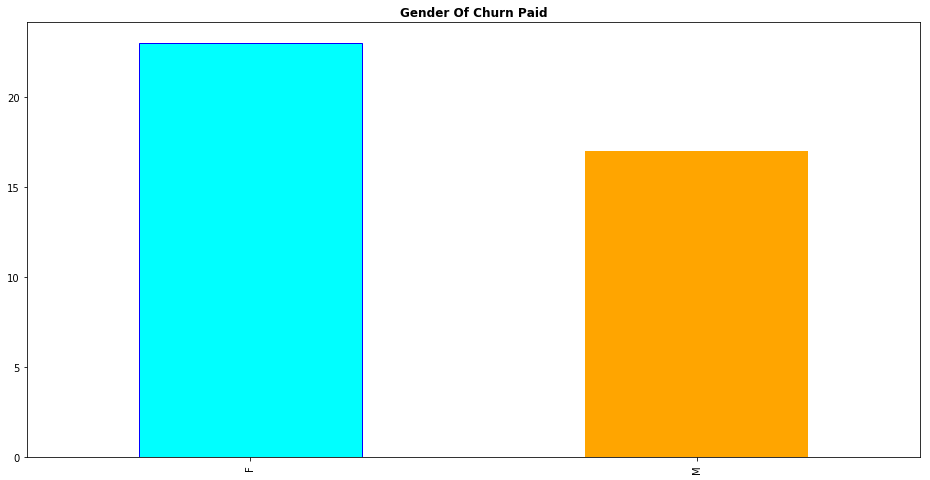

In [39]:
#Display bar to gender_of_churn_paid
display_bar_chart(gender_of_churn_paid, "gender", "Gender Of Churn Paid")

In [44]:
gender_of_churn_cancelled.head(10)

,userId,gender
0,125,M
1,51,M
2,100014,M
3,101,M
4,100021,M
5,29,M
6,73,F
7,87,M
8,3,M
9,28,F


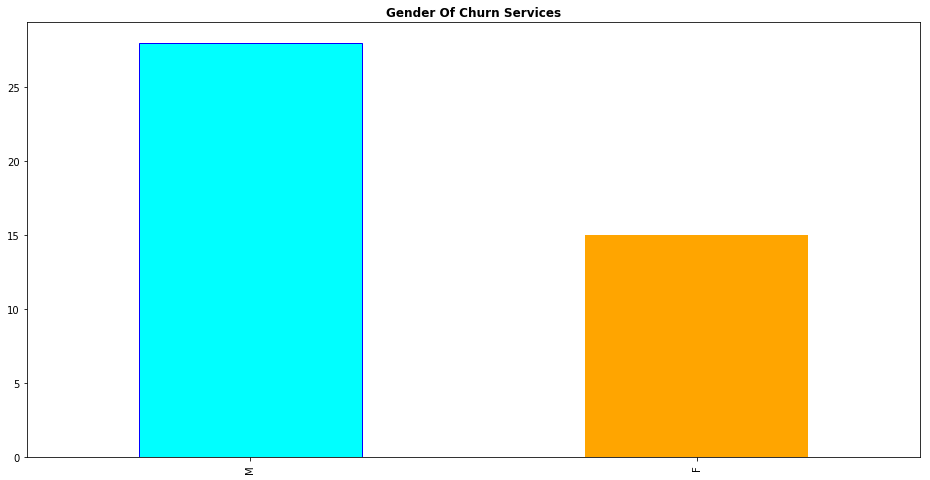

In [40]:
#Display bar to gender_of_churn_paid
display_bar_chart(gender_of_churn_cancelled, "gender", "Gender Of Churn Services")

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.